# Roughness prediction using DNN

In [ ]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import random
import hashlib
import pandas as pd
from tqdm import tqdm
import math
from sklearn.preprocessing import MinMaxScaler
import copy

# Data and preprocessing

In [ ]:
class RandomHashFunction:
    def __init__(self, seed=None):
        self.seed = seed or random.randint(0, 2**32 - 1)
        random.seed(self.seed)
        self.salt = random.random()

    def forward(self, vector, min_val=0, max_val=10, output_type='float'):
        if vector.shape != (6, ):
            raise ValueError("Only vector shape (1, 6)")
        if output_type not in ['float', 'int']:
            raise ValueError("Unsupported type")

        salted_tensor = vector + self.salt
        input_str = ",".join(f"{x.item():.6f}" for x in salted_tensor.squeeze())
        hashed_value = hashlib.sha256(input_str.encode()).hexdigest()

        hashed_value = int(hashed_value, 16)
        normalized = hashed_value / (2**256 - 1)

        y = min_val + normalized * (max_val - min_val)

        if output_type == 'int':
            return int(y)
        elif output_type == 'float':
            return y

        # y = math.sin(vector[0]) + math.cos(vector[1]) + math.sin(vector[2]) + math.cos(vector[3]) + math.sin(vector[4]) + math.cos(vector[5])
        # normalized = 1 / (1 + math.exp(-y))

        # normalized = vector[0] + vector[1] + vector[2] + vector[3] + vector[4] + vector[5]
        # normalized = 1 / (1 + math.exp(-normalized))

        return min_val + normalized * (max_val - min_val)


class Dummy_data_generator:
    def __init__(self, num_samples=100, val_range=[0, 10], target = 'roughness',
                 feature_columns = ["Accel X (m/s^2)", "Accel Y", "Accel Z", "Rot_vel_X (m/s)", "Rot_vel_Y", "Rot_vel_Z"]):
        self.num_samples = num_samples
        self.feature_columns = feature_columns
        self.min_val = val_range[0]
        self.max_val = val_range[1]
        self.target = target

    def generate_target(self, vector):
        hash_function = RandomHashFunction()
        return hash_function.forward(vector, min_val=self.min_val, max_val=self.max_val)

    def generate_data_with_full_label(self):
        data = {i: np.random.uniform(-10, 10, self.num_samples) for i in self.feature_columns}

        data_matrix = np.array([data[col] for col in self.feature_columns]).T
        target_vals = [self.generate_target(row) for row in data_matrix]
        data[self.target] = target_vals
        return data


class SensorDataSet(Dataset):
    def __init__(self, dataframe):
        self.features = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)  # except last col
        self.targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)   # only last col

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Model and training pipeline

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.Linear(128, 256),
            # # nn.BatchNorm1d(256),
            # nn.ReLU(),
            # nn.Linear(256, 128),
            # # nn.BatchNorm1d(128),
            # # nn.Dropout(p=0.3),
            # nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20, diplay_step=5, lr_scheduler=None):
    # model = copy.deepcopy(model)
    val_loss_history = []
    train_loss_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        num_data = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Training epooch {epoch+1}", leave=False):
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            if lr_scheduler is not None and epoch < 1:
                lr_scheduler.step()

            train_loss += loss.item()
            num_data += X_batch.shape[0]

        train_loss = train_loss / num_data
        train_loss_history.append(train_loss)

        # evaluate
        val_loss = validate_model(model, criterion, val_loader)
        val_loss_history.append(val_loss)

        if (epoch+1)%diplay_step==0 or epoch==0:
            for param_group in optimizer.param_groups:
                lr = param_group['lr']

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, learning rate = {lr}")

    return train_loss_history, val_loss_history

def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    num_data = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            num_data += X_batch.shape[0]

    return val_loss / num_data

# Train and evaluation

In [ ]:
val_range=[0, 10]
generator = Dummy_data_generator(num_samples=6250, val_range=val_range)
data = generator.generate_data_with_full_label()
data = pd.DataFrame(data)
data

,Accel X (m/s^2),Accel Y,Accel Z,Rot_vel_X (m/s),Rot_vel_Y,Rot_vel_Z,roughness
0,-5.366460,-2.123762,8.625339,8.842375,4.268395,0.559261,5.820496
1,9.995139,-8.998163,3.470958,9.940691,-1.087181,-6.137474,3.772169
2,-8.612802,-9.566269,-6.367733,-8.228374,0.487648,5.040437,7.999552
3,9.286000,7.486985,2.033939,7.050390,-1.041939,-3.614210,0.009742
4,-3.952218,-0.947475,1.100600,-2.444226,-7.074652,6.463275,2.231430
...,...,...,...,...,...,...,...
6245,8.618922,-7.019564,-6.186766,8.149796,4.139276,-9.392455,5.010220
6246,7.152085,-7.592141,7.889470,-1.728077,9.885148,8.596147,2.575856
6247,7.789633,6.775151,3.016157,-7.135658,8.826974,6.800422,4.968458
6248,-9.532771,4.001386,7.883589,-5.173128,1.710646,8.720628,3.590543


In [ ]:
# scaler = MinMaxScaler()
# col_to_scale = [i for i in data.columns]
# normalized_data = pd.DataFrame(scaler.fit_transform(data[col_to_scale]), columns=col_to_scale)


# normalized_data

In [ ]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

train_set_ = SensorDataSet(train_set)
val_set_ = SensorDataSet(val_set)
# dataset = SensorDataSet(normalized_data)
batch_size = 256
train_loader = DataLoader(train_set_, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_, batch_size=batch_size, shuffle=True)

In [ ]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

validate_model(model, criterion, val_loader)

0.12096827697753906

Epoch 1/250, Train Loss: 0.0593, Val Loss: 0.0424, learning rate = 0.00049


Epoch 10/250, Train Loss: 0.0352, Val Loss: 0.0376, learning rate = 0.00049


Epoch 20/250, Train Loss: 0.0343, Val Loss: 0.0370, learning rate = 0.00049


Epoch 30/250, Train Loss: 0.0334, Val Loss: 0.0365, learning rate = 0.00049


Epoch 40/250, Train Loss: 0.0320, Val Loss: 0.0359, learning rate = 0.00049


Epoch 50/250, Train Loss: 0.0307, Val Loss: 0.0357, learning rate = 0.00049


Epoch 60/250, Train Loss: 0.0299, Val Loss: 0.0357, learning rate = 0.00049


Epoch 70/250, Train Loss: 0.0294, Val Loss: 0.0357, learning rate = 0.00049


Epoch 80/250, Train Loss: 0.0286, Val Loss: 0.0362, learning rate = 0.00049


Epoch 90/250, Train Loss: 0.0280, Val Loss: 0.0363, learning rate = 0.00049


Epoch 100/250, Train Loss: 0.0273, Val Loss: 0.0367, learning rate = 0.00049


Epoch 110/250, Train Loss: 0.0273, Val Loss: 0.0378, learning rate = 0.00049


Epoch 120/250, Train Loss: 0.0263, Val Loss: 0.0374, learning rate = 0.00049


Epoch 130/250, Train Loss: 0.0257, Val Loss: 0.0382, learning rate = 0.00049


Epoch 140/250, Train Loss: 0.0252, Val Loss: 0.0382, learning rate = 0.00049


Epoch 150/250, Train Loss: 0.0246, Val Loss: 0.0387, learning rate = 0.00049


Epoch 160/250, Train Loss: 0.0246, Val Loss: 0.0390, learning rate = 0.00049


Epoch 170/250, Train Loss: 0.0233, Val Loss: 0.0394, learning rate = 0.00049


Epoch 180/250, Train Loss: 0.0227, Val Loss: 0.0397, learning rate = 0.00049


Epoch 190/250, Train Loss: 0.0225, Val Loss: 0.0404, learning rate = 0.00049


Epoch 200/250, Train Loss: 0.0215, Val Loss: 0.0418, learning rate = 0.00049


Epoch 210/250, Train Loss: 0.0210, Val Loss: 0.0414, learning rate = 0.00049


Epoch 220/250, Train Loss: 0.0207, Val Loss: 0.0416, learning rate = 0.00049


Epoch 230/250, Train Loss: 0.0199, Val Loss: 0.0418, learning rate = 0.00049


Epoch 240/250, Train Loss: 0.0195, Val Loss: 0.0431, learning rate = 0.00049


Epoch 250/250, Train Loss: 0.0190, Val Loss: 0.0430, learning rate = 0.00049


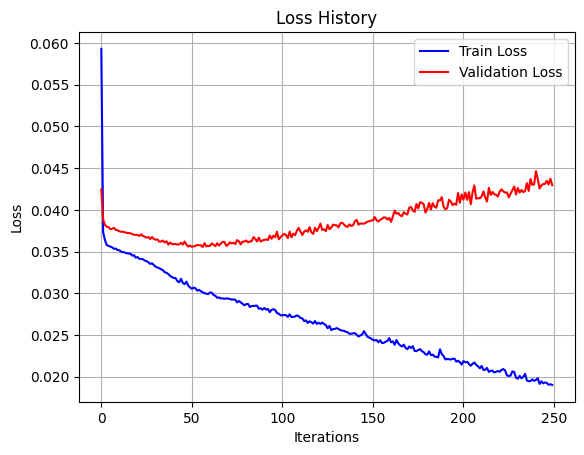

In [ ]:
train_loss_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=250, diplay_step=10, lr_scheduler=lr_scheduler)

plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_set = train_set
untrained_model = Net()

i = random.randint(0, len(test_set)-1)
print(test_set.iloc[i, :])

x = np.array(test_set)[i, :-1]
x = torch.tensor(x, dtype=torch.float32)
x = x.unsqueeze(0)

print()

print(f'predicted roughness by trained model: {model(x).item()}')
print(f'predicted roughness by untrained model: {untrained_model(x).item()}')

Accel X (m/s^2)    1.343874
Accel Y            5.015706
Accel Z            6.566715
Rot_vel_X (m/s)   -1.282153
Rot_vel_Y         -7.210584
Rot_vel_Z         -4.951504
roughness          2.082249
Name: 4984, dtype: float64

predicted roughness by trained model: 4.138833045959473
predicted roughness by untrained model: -0.21976375579833984


## Summarization:
- Simple DNN can learn underlying relation in 6d data
- Relatively fast training with small dimensionality
- Overfitting issue hurts performance. Attempts:
    - Reduce model size
    - Add batchnorm, dropout
    - Increase batch_size
    - Learning rate scheduler (decaying)

## Future work:
- Test on real data
- Explore other architectures
- Physics-informed model + other regularization technique to improve generalization and robustness
- Finetunig hyperparameters (learning rate, model size, depth, etc.), architecture search for automatic finetuning.


# Concerns:
- Regarding simulation: Tool for simulation (Simulink, MATLAB, labview, ROS, etc)? How can we attain the Robot arm and surface model (for simulation)?
- Which kind of controller we plan to use for our system??
- How can we actually integrate trained DNN to our simulation (some available refernces ? ) ??
